**Cell 1 — Install + Imports**

In [81]:
!pip -q install albumentations==1.4.7 opencv-python-headless==4.10.0.84 scipy==1.11.4

import os, re, time, math, random
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold

import albumentations as A
from albumentations.pytorch import ToTensorV2

from scipy.stats import wilcoxon


**Cell 2 — Config + Paths + Repro**

In [82]:
IMG_DIR = Path("/kaggle/input/er-segmentation/ER_IHC_Image/ER_IHC_Int_Image")
MSK_DIR = Path("/kaggle/input/er-segmentation/ER_IHC_Mask/Mask_WO_BG")

OUT_DIR = Path("/kaggle/working/er_final_runs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

print("DEVICE:", DEVICE)
print("IMG count:", len(list(IMG_DIR.glob("*.png"))))
print("MSK count:", len(list(MSK_DIR.glob("*.png"))))


DEVICE: cuda
IMG count: 220
MSK count: 220


**Cell 3 — Label Map (RGB → Class ID)**

In [83]:
NUM_CLASSES = 5

# 0 bg, 1 normal (cyan), 2 weak (green), 3 moderate (yellow), 4 strong (red)
COLOR_TO_ID = {
    (0, 0, 0): 0,
    (0, 159, 255): 1,
    (0, 255, 0): 2,
    (255, 216, 0): 3,
    (255, 0, 0): 4,
}

ID_TO_NAME = {
    0: "Background",
    1: "Normal",
    2: "Weak",
    3: "Moderate",
    4: "Strong",
}

def mask_rgb_to_ids(mask_rgb: np.ndarray, tolerance: int = 0) -> np.ndarray:
    """HxWx3 uint8 RGB -> HxW uint8 class ids."""
    h, w, _ = mask_rgb.shape
    out = np.zeros((h, w), dtype=np.uint8)
    for (r,g,b), cid in COLOR_TO_ID.items():
        if tolerance <= 0:
            m = (mask_rgb[:,:,0]==r) & (mask_rgb[:,:,1]==g) & (mask_rgb[:,:,2]==b)
        else:
            m = (np.abs(mask_rgb[:,:,0]-r)<=tolerance) & (np.abs(mask_rgb[:,:,1]-g)<=tolerance) & (np.abs(mask_rgb[:,:,2]-b)<=tolerance)
        out[m] = cid
    return out


**Cell 4 — Deterministic Pairing (Image_i ↔ mask_i)**

In [84]:
def extract_id(stem: str):
    m = re.search(r"(\d+)$", stem)
    return int(m.group(1)) if m else None

img_files = sorted(IMG_DIR.glob("*.png"))
msk_files = sorted(MSK_DIR.glob("*.png"))

mask_by_id = {}
for p in msk_files:
    i = extract_id(p.stem)
    if i is not None:
        mask_by_id[i] = p

pairs = []
missing = []
for img in img_files:
    i = extract_id(img.stem)
    if i is None:
        continue
    if i not in mask_by_id:
        missing.append(i)
        continue
    pairs.append((img, mask_by_id[i], i))

print("Pairs:", len(pairs))
print("Missing ids:", missing[:10])
assert len(pairs) > 0 and len(missing) == 0


Pairs: 220
Missing ids: []


**Cell 5 — Load mask IDs + Quick Dataset Summary (imbalance & presence)**

Pixel frequency: {'Background': 0.764215122569691, 'Normal': 0.17700236927379262, 'Weak': 0.015368582985617898, 'Moderate': 0.025952755321155895, 'Strong': 0.017461169849742542}


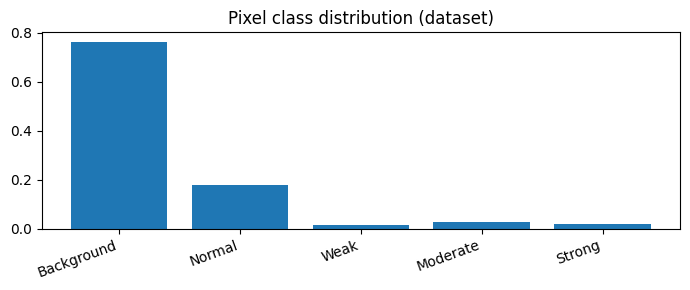

Images with class2: 127 class3: 93 class4: 65


In [85]:
def load_mask_ids(msk_path: Path):
    m = Image.open(msk_path)
    if m.mode in ("RGBA","LA"):
        m = m.convert("RGB")
    arr = np.array(m, dtype=np.uint8)
    return mask_rgb_to_ids(arr, tolerance=0)

counts = np.zeros(NUM_CLASSES, dtype=np.int64)
presence_234 = np.zeros((len(pairs), 3), dtype=np.int64)
fg_frac = []

for k, (_, msk, _) in enumerate(pairs):
    lbl = load_mask_ids(msk)
    for c in range(NUM_CLASSES):
        counts[c] += (lbl==c).sum()
    fg_frac.append(float((lbl>0).mean()))
    presence_234[k,0] = int((lbl==2).any())
    presence_234[k,1] = int((lbl==3).any())
    presence_234[k,2] = int((lbl==4).any())

freq = counts / counts.sum()
print("Pixel frequency:", {ID_TO_NAME[i]: float(freq[i]) for i in range(NUM_CLASSES)})

summary_df = pd.DataFrame({
    "id": [pid for *_, pid in pairs],
    "has_2": presence_234[:,0],
    "has_3": presence_234[:,1],
    "has_4": presence_234[:,2],
    "fg_frac": fg_frac
})
summary_df.to_csv(OUT_DIR/"data_summary.csv", index=False)

plt.figure(figsize=(7,3))
plt.bar([ID_TO_NAME[i] for i in range(NUM_CLASSES)], freq)
plt.xticks(rotation=20, ha="right")
plt.title("Pixel class distribution (dataset)")
plt.tight_layout()
plt.savefig(OUT_DIR/"class_distribution.png", dpi=200)
plt.show()

print("Images with class2:", int(summary_df["has_2"].sum()),
      "class3:", int(summary_df["has_3"].sum()),
      "class4:", int(summary_df["has_4"].sum()))


**Cell 6 — Stratified 5-Fold CV Labels (presence of rare classes 2/3/4)**

In [86]:
def strat_label_from_mask(lbl: np.ndarray) -> int:
    """
    Updated strat label:
    - Encodes presence of classes (2,3,4) into 0..7 bits.
    - Adds a fallback label for 'any foreground' (class1) to avoid empty/rare strata issues.
    """
    has1 = int((lbl == 1).any())
    has2 = int((lbl == 2).any())
    has3 = int((lbl == 3).any())
    has4 = int((lbl == 4).any())

    # bits for 2/3/4
    bits = has2 + 2*has3 + 4*has4

    # If there is no lesion (2/3/4), still separate cases with/without class1
    # 0 -> only background
    # 8 -> has class1 but no (2/3/4)
    if bits == 0 and has1 == 1:
        return 8
    return bits

strat_labels = np.array(
    [strat_label_from_mask(load_mask_ids(msk)) for _, msk, _ in pairs],
    dtype=np.int64
)

print("Strata counts:", pd.Series(strat_labels).value_counts().sort_index().to_dict())


Strata counts: {1: 49, 3: 28, 6: 15, 7: 50, 8: 78}


**Cell 7 — Training Settings (advanced but “clean”)**

In [87]:
# Keep augmentation minimal for "clean" methodology; still helpful for 220 images.
USE_GEO_AUG = True  # set False to disable augmentation

# Training crops & sampling
CROP_SIZE = 256
SAMPLES_PER_IMAGE = 4   # virtual oversampling (small dataset + rare classes)
FOCUS_PROB = 0.95

# CV / training schedule
FOLDS = 5
EPOCHS = 100
BATCH = 8               # reduce if OOM

# ✅ More stable peak LR for scratch (prevents collapse in some folds)
LR = 5e-4               # was 8e-4
WD = 1e-4
PATIENCE = 10           # slightly more patience since training is more stable

# Deep supervision
AUX_LOSS_WEIGHT = 0.2

# EMA (usually helps)
USE_EMA = True
EMA_DECAY = 0.999


**Cell 8 — Dataset (rare-class focused crops + “guarantee class 3/4 crops”)**

In [88]:
# From-scratch friendly normalization (simple [0,1])
NORM_MEAN = (0.0, 0.0, 0.0)
NORM_STD  = (1.0, 1.0, 1.0)

class ERDataset(Dataset):
    """
    Updated:
    - Balanced crop sampling: (1) guarantee rare classes (3/4), (2) lesion focus (2-4),
      (3) foreground focus (1-4), (4) random.
    - Normalization suited for training from scratch: scale to [0,1] (no ImageNet stats).
    """

    def __init__(
        self,
        pairs,
        train: bool,
        crop_size=256,
        samples_per_image=2,
        focus_prob=0.95,                 # kept for compatibility; actual probabilities below
        guarantee_classes=(3,4),
        use_geo_aug=True,
        # new knobs (you can leave defaults)
        p_lesion=0.45,                   # probability crop centered on class 2-4
        p_fg=0.35,                       # probability crop centered on class 1-4
        # remaining probability goes to random
    ):
        self.pairs = pairs
        self.train = train
        self.crop_size = crop_size
        self.samples_per_image = samples_per_image if train else 1
        self.focus_prob = focus_prob
        self.guarantee_classes = guarantee_classes
        self.use_geo_aug = use_geo_aug

        self.p_lesion = p_lesion
        self.p_fg = p_fg

        if train and use_geo_aug:
            self.tf = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.Normalize(mean=NORM_MEAN, std=NORM_STD, max_pixel_value=255.0),
                ToTensorV2(),
            ])
        else:
            self.tf = A.Compose([
                A.Normalize(mean=NORM_MEAN, std=NORM_STD, max_pixel_value=255.0),
                ToTensorV2(),
            ])

        self._gcur = 0

    def __len__(self):
        return len(self.pairs) * self.samples_per_image

    def _load(self, base_idx):
        img_path, msk_path, pid = self.pairs[base_idx]
        img = np.array(Image.open(img_path).convert("RGB"), dtype=np.uint8)

        m = Image.open(msk_path)
        if m.mode in ("RGBA", "LA"):
            m = m.convert("RGB")
        mask_rgb = np.array(m, dtype=np.uint8)
        lbl = mask_rgb_to_ids(mask_rgb, tolerance=0)
        return img, lbl, pid

    def _crop(self, img, lbl):
        H, W = lbl.shape
        cs = self.crop_size

        fg = (lbl >= 1)       # class 1..4
        lesion = (lbl >= 2)   # class 2..4

        # 1) guarantee rare class crop if present (rotating among guarantee_classes)
        do_guarantee = False
        gclass = None
        if self.train and self.guarantee_classes:
            gclass = self.guarantee_classes[self._gcur % len(self.guarantee_classes)]
            if (lbl == gclass).any():
                do_guarantee = True
            self._gcur += 1

        r = np.random.rand()

        if do_guarantee:
            ys, xs = np.where(lbl == gclass)
            k = np.random.randint(0, len(ys))
            cy, cx = ys[k], xs[k]

        # 2) lesion-focused (2-4)
        elif self.train and lesion.any() and (r < self.p_lesion):
            ys, xs = np.where(lesion)
            k = np.random.randint(0, len(ys))
            cy, cx = ys[k], xs[k]

        # 3) foreground-focused (1-4)
        elif self.train and fg.any() and (r < self.p_lesion + self.p_fg):
            ys, xs = np.where(fg)
            k = np.random.randint(0, len(ys))
            cy, cx = ys[k], xs[k]

        # 4) random crop
        else:
            cy, cx = np.random.randint(0, H), np.random.randint(0, W)

        y1 = int(np.clip(cy - cs//2, 0, H - cs))
        x1 = int(np.clip(cx - cs//2, 0, W - cs))

        return img[y1:y1+cs, x1:x1+cs], lbl[y1:y1+cs, x1:x1+cs]

    def __getitem__(self, idx):
        base_idx = idx // self.samples_per_image
        img, lbl, pid = self._load(base_idx)

        if self.train:
            img, lbl = self._crop(img, lbl)

        out = self.tf(image=img, mask=lbl)
        x = out["image"].float()
        y = out["mask"].long()
        return x, y, {"id": pid}


**Cell 9 — Novel Model: Custom DeepLabV3+ (scratch) + Deep Supervision (aux head)**

In [89]:
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, k, s, p, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class ASPP(nn.Module):
    def __init__(self, in_ch, out_ch, rates=(6,12,18)):
        super().__init__()
        self.b0 = ConvBNReLU(in_ch, out_ch, k=1, p=0)
        self.b1 = nn.Sequential(nn.Conv2d(in_ch,out_ch,3,padding=rates[0],dilation=rates[0],bias=False),
                                nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True))
        self.b2 = nn.Sequential(nn.Conv2d(in_ch,out_ch,3,padding=rates[1],dilation=rates[1],bias=False),
                                nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True))
        self.b3 = nn.Sequential(nn.Conv2d(in_ch,out_ch,3,padding=rates[2],dilation=rates[2],bias=False),
                                nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True))
        self.gp = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                                nn.Conv2d(in_ch,out_ch,1,bias=False),
                                nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True))
        self.proj = ConvBNReLU(out_ch*5, out_ch, k=1, p=0)

    def forward(self, x):
        h,w = x.shape[-2:]
        x0 = self.b0(x)
        x1 = self.b1(x)
        x2 = self.b2(x)
        x3 = self.b3(x)
        x4 = self.gp(x)
        x4 = F.interpolate(x4, size=(h,w), mode="bilinear", align_corners=False)
        return self.proj(torch.cat([x0,x1,x2,x3,x4], dim=1))

class CustomDeepLabV3Plus_DS(nn.Module):
    """
    Novelty: from-scratch DeepLabV3+ style + Deep Supervision (aux head).
    Returns:
      main_logits: [B,C,H,W]
      aux_logits : [B,C,H/4,W/4]  (or similar)
    """
    def __init__(self, num_classes=NUM_CLASSES, base=64):
        super().__init__()
        # encoder (scratch)
        self.stem = nn.Sequential(
            ConvBNReLU(3, base, 3, 2, 1),   # /2
            ConvBNReLU(base, base, 3, 1, 1),
        )
        self.e1 = nn.Sequential(ConvBNReLU(base, base*2, 3, 2, 1), ConvBNReLU(base*2, base*2))   # /4
        self.e2 = nn.Sequential(ConvBNReLU(base*2, base*4, 3, 2, 1), ConvBNReLU(base*4, base*4)) # /8
        self.e3 = nn.Sequential(ConvBNReLU(base*4, base*8, 3, 2, 1), ConvBNReLU(base*8, base*8)) # /16

        self.aspp = ASPP(base*8, base*8)
        self.low = ConvBNReLU(base*2, base, k=1, p=0)  # from /4 feature

        # decoder
        self.dec = nn.Sequential(
            ConvBNReLU(base*8 + base, base*4),
            ConvBNReLU(base*4, base*2),
            nn.Dropout2d(0.1),
        )
        self.head = nn.Conv2d(base*2, num_classes, 1)

        # deep supervision aux head at /8 (e2 output)
        self.aux = nn.Sequential(
            ConvBNReLU(base*4, base*2, k=1, p=0),
            nn.Dropout2d(0.1),
            nn.Conv2d(base*2, num_classes, 1)
        )

    def forward(self, x):
        x0 = self.stem(x)   # /2
        x1 = self.e1(x0)    # /4
        x2 = self.e2(x1)    # /8
        x3 = self.e3(x2)    # /16

        aux_logits = self.aux(x2)  # /8 deep supervision

        y = self.aspp(x3)
        y = F.interpolate(y, size=x1.shape[-2:], mode="bilinear", align_corners=False)
        y = torch.cat([y, self.low(x1)], dim=1)
        y = self.dec(y)
        y = self.head(y)
        y = F.interpolate(y, size=x.shape[-2:], mode="bilinear", align_corners=False)
        return y, aux_logits


In [90]:
from torchinfo import summary

model = CustomDeepLabV3Plus_DS(num_classes=NUM_CLASSES, base=64)
summary(model, input_size=(1, 3, 512, 512))  # batch, channels, H, W


Layer (type:depth-idx)                   Output Shape              Param #
CustomDeepLabV3Plus_DS                   [1, 5, 512, 512]          --
├─Sequential: 1-1                        [1, 64, 256, 256]         --
│    └─ConvBNReLU: 2-1                   [1, 64, 256, 256]         --
│    │    └─Sequential: 3-1              [1, 64, 256, 256]         1,856
│    └─ConvBNReLU: 2-2                   [1, 64, 256, 256]         --
│    │    └─Sequential: 3-2              [1, 64, 256, 256]         36,992
├─Sequential: 1-2                        [1, 128, 128, 128]        --
│    └─ConvBNReLU: 2-3                   [1, 128, 128, 128]        --
│    │    └─Sequential: 3-3              [1, 128, 128, 128]        73,984
│    └─ConvBNReLU: 2-4                   [1, 128, 128, 128]        --
│    │    └─Sequential: 3-4              [1, 128, 128, 128]        147,712
├─Sequential: 1-3                        [1, 256, 64, 64]          --
│    └─ConvBNReLU: 2-5                   [1, 256, 64, 64]          --

**Cell 10 — Class-Balanced Loss: CE + Dice + Focal-Tversky (+ aux loss)**

In [91]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------- weights ----------
def effective_num_weights(counts, beta=0.9999):
    """
    Class-balanced weights using effective number of samples.
    counts: array-like length = NUM_CLASSES (pixel counts per class)
    """
    counts = np.array(counts, dtype=np.float64)
    eff = (1.0 - np.power(beta, counts)) / (1.0 - beta + 1e-12)
    w = 1.0 / (eff + 1e-12)
    w = w / (w.mean() + 1e-12)
    return w

def compute_train_class_counts(train_pairs):
    counts = np.zeros(NUM_CLASSES, dtype=np.int64)
    for _, msk, _ in train_pairs:
        lbl = load_mask_ids(msk)
        for c in range(NUM_CLASSES):
            counts[c] += (lbl == c).sum()
    return counts


# ---------- losses ----------
class DiceLossFG(nn.Module):
    """
    Foreground-only Dice (classes 1..NUM_CLASSES-1) and ignores empty classes.
    This prevents "all-background" collapse and avoids penalizing absent classes.
    """
    def __init__(self, num_classes=NUM_CLASSES, eps=1e-6, ignore_empty=True):
        super().__init__()
        self.num_classes = num_classes
        self.eps = eps
        self.ignore_empty = ignore_empty

    def forward(self, logits, target):
        # logits [B,C,H,W], target [B,H,W]
        probs = F.softmax(logits, dim=1)
        onehot = F.one_hot(target, self.num_classes).permute(0,3,1,2).float()

        # remove background channel
        probs_fg = probs[:, 1:]         # [B, C-1, H, W]
        onehot_fg = onehot[:, 1:]       # [B, C-1, H, W]

        dims = (0, 2, 3)
        inter = (probs_fg * onehot_fg).sum(dims)
        denom = (probs_fg + onehot_fg).sum(dims)
        dice = (2.0 * inter + self.eps) / (denom + self.eps)   # [C-1]

        if self.ignore_empty:
            present = (onehot_fg.sum(dims) > 0)  # which classes exist in target
            if present.any():
                dice = dice[present]
            else:
                # no foreground at all -> do not penalize dice
                return logits.sum() * 0.0

        return 1.0 - dice.mean()


class FocalTverskyLossFG(nn.Module):
    """
    Foreground-only Focal Tversky, ignoring empty classes.
    Use only AFTER training is stable; otherwise CE+DiceFG is safer.
    """
    def __init__(self, num_classes=NUM_CLASSES, alpha=0.7, beta=0.3, gamma=0.75, eps=1e-6, ignore_empty=True):
        super().__init__()
        self.num_classes=num_classes
        self.alpha=alpha
        self.beta=beta
        self.gamma=gamma
        self.eps=eps
        self.ignore_empty = ignore_empty

    def forward(self, logits, target):
        probs = F.softmax(logits, dim=1)
        onehot = F.one_hot(target, self.num_classes).permute(0,3,1,2).float()

        # remove background
        probs = probs[:, 1:]
        onehot = onehot[:, 1:]

        dims = (0,2,3)
        tp = (probs * onehot).sum(dims)
        fp = (probs * (1 - onehot)).sum(dims)
        fn = ((1 - probs) * onehot).sum(dims)

        tversky = (tp + self.eps) / (tp + self.alpha*fp + self.beta*fn + self.eps)
        loss = torch.pow((1.0 - tversky), self.gamma)  # [C-1]

        if self.ignore_empty:
            present = (onehot.sum(dims) > 0)
            if present.any():
                loss = loss[present]
            else:
                return logits.sum() * 0.0

        return loss.mean()


class ComboLoss(nn.Module):
    """
    Safer combo loss:
      - Weighted CE (all classes including background)
      - Foreground Dice (ignores BG and ignores empty classes)

    Start with use_tversky=False (recommended) until the model stops collapsing.
    """
    def __init__(self, ce_w, w_ce=1.0, w_dice=1.0, w_ft=0.0, use_tversky=False):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=ce_w)
        self.dice = DiceLossFG()
        self.use_tversky = use_tversky
        self.ft = FocalTverskyLossFG() if use_tversky else None

        self.w_ce = w_ce
        self.w_dice = w_dice
        self.w_ft = w_ft

    def forward(self, logits, target):
        loss = self.w_ce * self.ce(logits, target) + self.w_dice * self.dice(logits, target)
        if self.use_tversky and self.w_ft > 0:
            loss = loss + self.w_ft * self.ft(logits, target)
        return loss


**Cell 11 — EMA (Exponential Moving Average) for Stability/Performance**

In [92]:
class EMA:
    def __init__(self, model: nn.Module, decay=0.999):
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        for name, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[name] = p.data.clone()

    @torch.no_grad()
    def update(self, model: nn.Module):
        for name, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[name] = self.decay * self.shadow[name] + (1.0 - self.decay) * p.data

    def apply_shadow(self, model: nn.Module):
        self.backup = {}
        for name, p in model.named_parameters():
            if p.requires_grad:
                self.backup[name] = p.data.clone()
                p.data = self.shadow[name].clone()

    def restore(self, model: nn.Module):
        for name, p in model.named_parameters():
            if p.requires_grad and name in self.backup:
                p.data = self.backup[name].clone()
        self.backup = {}


**Cell 12 — Metrics (confusion matrix → PixelAcc, IoU, Dice; noBG variants)**

In [93]:
@torch.no_grad()
def fast_cm(pred, target, num_classes=NUM_CLASSES):
    k = (target >= 0) & (target < num_classes)
    inds = num_classes * target[k].view(-1) + pred[k].view(-1)
    cm = torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)
    return cm

def metrics_from_cm(cm: torch.Tensor):
    cm = cm.float()
    diag = torch.diag(cm)
    total = cm.sum()

    pixel_acc = (diag.sum() / (total + 1e-8)).item()

    gt = cm.sum(dim=1)
    pr = cm.sum(dim=0)
    union = gt + pr - diag
    iou = (diag / (union + 1e-8)).cpu().numpy()
    dice = (2*diag / (gt + pr + 1e-8)).cpu().numpy()

    # excluding background (class 0)
    miou_no_bg  = float(np.nanmean(iou[1:]))
    mdice_no_bg = float(np.nanmean(dice[1:]))

    minority_dice = float(np.nanmean(dice[2:5]))  # classes 2..4

    return {
        "pixel_acc": pixel_acc,
        "iou_per_class": iou,
        "miou": float(np.nanmean(iou)),
        "dice_per_class": dice,
        "mdice": float(np.nanmean(dice)),
        "miou_no_bg": miou_no_bg,
        "mdice_no_bg": mdice_no_bg,
        "minority_dice": minority_dice
    }

@torch.no_grad()
def tta_logits(model, x):
    # flips TTA, average logits
    # model returns (main, aux), use main only
    logits0, _ = model(x)
    logits1, _ = model(torch.flip(x, dims=[3]))  # hflip
    logits1 = torch.flip(logits1, dims=[3])
    logits2, _ = model(torch.flip(x, dims=[2]))  # vflip
    logits2 = torch.flip(logits2, dims=[2])
    logits = (logits0 + logits1 + logits2) / 3.0
    return logits

@torch.no_grad()
def evaluate(model, loader, use_tta=False):
    model.eval()
    cm_total = torch.zeros((NUM_CLASSES, NUM_CLASSES), device=DEVICE)
    per_img_rows = []

    for x, y, meta in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        logits = tta_logits(model, x) if use_tta else model(x)[0]
        pred = logits.argmax(1)

        for b in range(x.size(0)):
            cm = fast_cm(pred[b], y[b], NUM_CLASSES).to(DEVICE)
            cm_total += cm
            m = metrics_from_cm(cm)
            per_img_rows.append({
                "id": int(meta["id"][b]),
                "pixel_acc": m["pixel_acc"],
                "miou": m["miou"],
                "mdice": m["mdice"],
                "miou_no_bg": m["miou_no_bg"],
                "mdice_no_bg": m["mdice_no_bg"],
                "minority_dice": m["minority_dice"],
                **{f"dice_c{c}": float(m["dice_per_class"][c]) for c in range(NUM_CLASSES)},
                **{f"iou_c{c}": float(m["iou_per_class"][c]) for c in range(NUM_CLASSES)},
            })

    summ = metrics_from_cm(cm_total)
    per_img = pd.DataFrame(per_img_rows)
    return summ, per_img, cm_total.detach().cpu().numpy()


Cell 12.5 —Overfit test (ID 105)

In [94]:
# =========================
# Cell 12.5 — Overfit One Image Debug (use id=105 which has class3 & class4)
# Run this BEFORE full CV. If this can't overfit, something is still wrong.
# =========================

from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Pick a guaranteed-lesion image (you confirmed id=105 has class3/class4)
one_pair = [p for p in pairs if p[2] == 105]
assert len(one_pair) == 1, f"Could not find id=105 in pairs. Found: {len(one_pair)}"

# Strong lesion sampling to make overfit easy
ds_one = ERDataset(
    one_pair,
    train=True,
    crop_size=CROP_SIZE,
    samples_per_image=120,
    focus_prob=0.95,
    guarantee_classes=(2,3,4),
    use_geo_aug=False,
    p_lesion=0.70,
    p_fg=0.25
)
dl_one = DataLoader(ds_one, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)

model = CustomDeepLabV3Plus_DS().to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# IMPORTANT: down-weight background to prevent trivial all-bg solution
ce_w = torch.tensor([0.2, 1.0, 2.0, 3.0, 3.0], dtype=torch.float32, device=DEVICE)
ce_only = nn.CrossEntropyLoss(weight=ce_w)

print("Starting overfit test on id=105 ...")
model.train()

for it, (x, y, meta) in enumerate(dl_one):
    x = x.to(DEVICE, non_blocking=True)
    y = y.to(DEVICE, non_blocking=True)

    opt.zero_grad(set_to_none=True)

    logits, aux = model(x)
    y_aux = F.interpolate(
        y.unsqueeze(1).float(),
        size=aux.shape[-2:],
        mode="nearest"
    ).squeeze(1).long()

    loss = ce_only(logits, y) + 0.2 * ce_only(aux, y_aux)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()

    if it % 20 == 0:
        pred = logits.argmax(1)
        cm = fast_cm(pred[0], y[0], NUM_CLASSES).cpu()
        m = metrics_from_cm(cm)

        # Show label distribution in this batch (ensures crops contain lesions)
        u, c = torch.unique(y[0].cpu(), return_counts=True)
        print("labels in sample:", list(zip(u.tolist(), c.tolist())))

        print(it,
              "loss", float(loss.item()),
              "| mdice_noBG", float(m["mdice_no_bg"]),
              "| minorityDice(2-4)", float(m["minority_dice"]))

    if it >= 300:
        break

print("Overfit test done. If mdice_noBG and minorityDice rose above 0, training is now working.")


Starting overfit test on id=105 ...
labels in sample: [(0, 60061), (2, 110), (3, 1372), (4, 3993)]
0 loss 1.8948239088058472 | mdice_noBG 0.0440666489303112 | minorityDice(2-4) 0.058755531907081604
labels in sample: [(0, 50219), (3, 5430), (4, 9887)]
20 loss 0.33130523562431335 | mdice_noBG 0.3466455936431885 | minorityDice(2-4) 0.4621941149234772
Overfit test done. If mdice_noBG and minorityDice rose above 0, training is now working.


**Cell 13 — Training Loop (AMP + Warmup+Cosine + Deep Supervision + EMA + Early stop)**

In [95]:
def warmup_cosine_lr(epoch, total_epochs, base_lr, warmup_epochs=5):
    if epoch < warmup_epochs:
        return base_lr * (epoch + 1) / warmup_epochs
    t = (epoch - warmup_epochs) / max(1, (total_epochs - warmup_epochs))
    return base_lr * 0.5 * (1 + math.cos(math.pi * t))


def plot_history(hist_df, out_path):
    plt.figure(figsize=(7,3))
    plt.plot(hist_df["epoch"], hist_df["train_loss"], label="train_loss")
    plt.plot(hist_df["epoch"], hist_df["val_minority_dice"], label="val_minority_dice")
    plt.plot(hist_df["epoch"], hist_df["val_mdice_no_bg"], label="val_mdice_no_bg")
    plt.xlabel("epoch"); plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()


def freeze_bn(m):
    # ✅ BN freeze for stability on small dataset
    if isinstance(m, nn.BatchNorm2d):
        m.eval()
        for p in m.parameters():
            p.requires_grad = False


def train_one_fold_custom(fold, train_pairs, val_pairs):
    fold_dir = OUT_DIR / f"fold{fold}"
    fold_dir.mkdir(parents=True, exist_ok=True)

    # ✅ UPDATED sampling: guarantee (2,3,4) + more lesion crops
    ds_tr = ERDataset(
        train_pairs, train=True, crop_size=CROP_SIZE,
        samples_per_image=SAMPLES_PER_IMAGE,
        focus_prob=FOCUS_PROB,
        guarantee_classes=(2,3,4),
        use_geo_aug=USE_GEO_AUG,
        p_lesion=0.60,
        p_fg=0.30
    )
    ds_va = ERDataset(
        val_pairs, train=False, crop_size=CROP_SIZE,
        samples_per_image=1, focus_prob=0.0,
        guarantee_classes=(),
        use_geo_aug=False
    )

    dl_tr = DataLoader(ds_tr, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
    dl_va = DataLoader(ds_va, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

    model = CustomDeepLabV3Plus_DS().to(DEVICE)

    # ✅ UPDATED weights: clip + DOWN-WEIGHT background + renormalize
    counts = compute_train_class_counts(train_pairs)
    w = effective_num_weights(counts, beta=0.9999)
    w = np.clip(w, 0.5, 5.0)

    w[0] = min(w[0], 0.2)   # critical: reduce background weight
    w = w / w.mean()        # renormalize

    ce_w = torch.tensor(w, dtype=torch.float32, device=DEVICE)
    print(f"[Fold {fold}] CE weights:", w)

    # ✅ CE-only warmup (longer = more stable)
    ce_only = nn.CrossEntropyLoss(weight=ce_w)

    # ✅ Stable combo after warmup (CE + DiceFG)
    main_loss = ComboLoss(ce_w, w_ce=1.0, w_dice=1.0, use_tversky=False)
    aux_loss  = ComboLoss(ce_w, w_ce=1.0, w_dice=1.0, use_tversky=False)

    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
    scaler = torch.amp.GradScaler("cuda", enabled=(DEVICE == "cuda"))

    ema = EMA(model, decay=EMA_DECAY) if USE_EMA else None

    best = -1e9
    bad = 0
    best_path = fold_dir / "custom_best.pt"
    hist = []

    for ep in range(EPOCHS):
        model.train()

        # ✅ Freeze BN each epoch (small dataset stability)
        model.apply(freeze_bn)

        lr_now = warmup_cosine_lr(ep, EPOCHS, LR, warmup_epochs=5)
        for g in opt.param_groups:
            g["lr"] = lr_now

        t0 = time.time()
        run_loss = 0.0

        for x, y, _ in dl_tr:
            x = x.to(DEVICE, non_blocking=True)
            y = y.to(DEVICE, non_blocking=True)

            opt.zero_grad(set_to_none=True)

            with torch.amp.autocast("cuda", enabled=(DEVICE == "cuda")):
                logits, aux = model(x)

                # aux target: downsample GT to aux resolution
                y_aux = F.interpolate(
                    y.unsqueeze(1).float(),
                    size=aux.shape[-2:],
                    mode="nearest"
                ).squeeze(1).long()

                # ✅ CE-only warmup first 10 epochs
                if ep < 10:
                    loss_main = ce_only(logits, y)
                    loss_aux  = ce_only(aux, y_aux)
                else:
                    loss_main = main_loss(logits, y)
                    loss_aux  = aux_loss(aux, y_aux)

                loss = loss_main + AUX_LOSS_WEIGHT * loss_aux

            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt)
            scaler.update()

            if ema is not None:
                ema.update(model)

            run_loss += loss.item() * x.size(0)

        train_loss = run_loss / len(dl_tr.dataset)

        # evaluate with EMA weights (if enabled)
        if ema is not None:
            ema.apply_shadow(model)
        val_summ, per_img, cm = evaluate(model, dl_va, use_tta=True)
        if ema is not None:
            ema.restore(model)

        score = val_summ["minority_dice"]

        hist.append({
            "epoch": ep+1,
            "lr": lr_now,
            "train_loss": train_loss,
            "val_pixel_acc": val_summ["pixel_acc"],
            "val_miou": val_summ["miou"],
            "val_mdice": val_summ["mdice"],
            "val_miou_no_bg": val_summ["miou_no_bg"],
            "val_mdice_no_bg": val_summ["mdice_no_bg"],
            "val_minority_dice": val_summ["minority_dice"],
        })

        print(f"[Fold {fold}] ep {ep+1:02d} "
              f"lr={lr_now:.2e} loss={train_loss:.4f} "
              f"mdice_noBG={val_summ['mdice_no_bg']:.4f} "
              f"minorDice(2-4)={val_summ['minority_dice']:.4f} "
              f"time={time.time()-t0:.1f}s")

        if score > best + 1e-4:
            best = score
            bad = 0
            if ema is not None:
                ema.apply_shadow(model)
            torch.save({"model": model.state_dict(), "epoch": ep+1, "best_minor": best}, best_path)
            if ema is not None:
                ema.restore(model)
        else:
            bad += 1
            if bad >= PATIENCE:
                print("Early stopping.")
                break

    hist_df = pd.DataFrame(hist)
    hist_df.to_csv(fold_dir/"custom_history.csv", index=False)
    plot_history(hist_df, fold_dir/"custom_curves.png")

    # load best and final eval (TTA)
    ck = torch.load(best_path, map_location=DEVICE)
    model.load_state_dict(ck["model"])
    val_summ, per_img, cm = evaluate(model, dl_va, use_tta=True)
    per_img.to_csv(fold_dir/"custom_per_image.csv", index=False)

    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix (pixels)")
    plt.xticks(range(NUM_CLASSES), [ID_TO_NAME[i] for i in range(NUM_CLASSES)], rotation=30, ha="right")
    plt.yticks(range(NUM_CLASSES), [ID_TO_NAME[i] for i in range(NUM_CLASSES)])
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(fold_dir/"custom_confusion_matrix.png", dpi=200)
    plt.close()

    return val_summ, per_img


**Cell 14 — Run 5-Fold CV (Custom model only, novelty focus)**

In [96]:
# ✅ 5-fold Stratified CV (using updated strat_labels that include 2/3/4 bits + class1 fallback)
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
pairs_arr = np.array(pairs, dtype=object)

all_summ = []
all_perimg = []

def fold_val_presence(val_pairs):
    has1 = has2 = has3 = has4 = 0
    for _, msk, _ in val_pairs:
        lbl = load_mask_ids(msk)
        has1 |= int((lbl == 1).any())
        has2 |= int((lbl == 2).any())
        has3 |= int((lbl == 3).any())
        has4 |= int((lbl == 4).any())
    return has1, has2, has3, has4

for fold, (tr_idx, va_idx) in enumerate(skf.split(np.zeros(len(pairs)), strat_labels)):
    seed_everything(SEED + fold)

    train_pairs = pairs_arr[tr_idx].tolist()
    val_pairs   = pairs_arr[va_idx].tolist()

    # ✅ save fold IDs for reproducibility
    pd.DataFrame({"id": [p[2] for p in val_pairs], "fold": fold}).to_csv(
        OUT_DIR / f"fold{fold}_val_ids.csv", index=False
    )

    # ✅ IMPORTANT: confirm val contains classes (1/2/3/4) across folds
    h1, h2, h3, h4 = fold_val_presence(val_pairs)
    print(f"[Fold {fold}] val presence: class1={h1}, class2={h2}, class3={h3}, class4={h4}")

    # ✅ also show strat label distribution in this fold
    va_labels = strat_labels[va_idx]
    print(f"[Fold {fold}] val strata counts:", pd.Series(va_labels).value_counts().sort_index().to_dict())

    # ✅ train & evaluate fold
    val_summ, per_img = train_one_fold_custom(fold, train_pairs, val_pairs)
    all_summ.append(val_summ)
    all_perimg.append(per_img)

    # ✅ save fold summary immediately
    fold_row = {
        "fold": fold,
        "pixel_acc": val_summ["pixel_acc"],
        "miou": val_summ["miou"],
        "mdice": val_summ["mdice"],
        "miou_no_bg": val_summ["miou_no_bg"],
        "mdice_no_bg": val_summ["mdice_no_bg"],
        "minority_dice": val_summ["minority_dice"],
        **{f"dice_c{c}": float(val_summ["dice_per_class"][c]) for c in range(NUM_CLASSES)},
        **{f"iou_c{c}": float(val_summ["iou_per_class"][c]) for c in range(NUM_CLASSES)},
    }
    pd.DataFrame([fold_row]).to_csv(OUT_DIR / f"fold{fold}_summary.csv", index=False)

print("Finished CV for Custom model.")

# ✅ save overall CV summaries too
cv_df = pd.DataFrame([
    {
        "fold": i,
        "pixel_acc": s["pixel_acc"],
        "miou": s["miou"],
        "mdice": s["mdice"],
        "miou_no_bg": s["miou_no_bg"],
        "mdice_no_bg": s["mdice_no_bg"],
        "minority_dice": s["minority_dice"],
        **{f"dice_c{c}": float(s["dice_per_class"][c]) for c in range(NUM_CLASSES)},
        **{f"iou_c{c}": float(s["iou_per_class"][c]) for c in range(NUM_CLASSES)},
    }
    for i, s in enumerate(all_summ)
])

cv_df.to_csv(OUT_DIR / "custom_cv_fold_summary.csv", index=False)
cv_df.agg(["mean", "std"]).to_csv(OUT_DIR / "custom_cv_mean_std.csv")

display(cv_df)
display(cv_df.agg(["mean","std"]))


[Fold 0] val presence: class1=1, class2=1, class3=1, class4=1
[Fold 0] val strata counts: {1: 10, 3: 5, 6: 3, 7: 10, 8: 16}
[Fold 0] CE weights: [0.23809524 1.19047619 1.19047619 1.19047619 1.19047619]
[Fold 0] ep 01 lr=1.00e-04 loss=1.4533 mdice_noBG=0.0087 minorDice(2-4)=0.0116 time=12.5s
[Fold 0] ep 02 lr=2.00e-04 loss=1.0258 mdice_noBG=0.0087 minorDice(2-4)=0.0116 time=12.7s
[Fold 0] ep 03 lr=3.00e-04 loss=0.8246 mdice_noBG=0.0087 minorDice(2-4)=0.0116 time=12.6s
[Fold 0] ep 04 lr=4.00e-04 loss=0.7803 mdice_noBG=0.1272 minorDice(2-4)=0.0510 time=12.7s
[Fold 0] ep 05 lr=5.00e-04 loss=0.7002 mdice_noBG=0.1723 minorDice(2-4)=0.1165 time=12.6s
[Fold 0] ep 06 lr=5.00e-04 loss=0.6557 mdice_noBG=0.1925 minorDice(2-4)=0.1457 time=12.9s
[Fold 0] ep 07 lr=5.00e-04 loss=0.5876 mdice_noBG=0.2095 minorDice(2-4)=0.1692 time=12.8s
[Fold 0] ep 08 lr=4.99e-04 loss=0.5514 mdice_noBG=0.2448 minorDice(2-4)=0.2104 time=12.4s
[Fold 0] ep 09 lr=4.99e-04 loss=0.5022 mdice_noBG=0.2717 minorDice(2-4)=0.2317

,fold,pixel_acc,miou,mdice,miou_no_bg,mdice_no_bg,minority_dice,dice_c0,dice_c1,dice_c2,dice_c3,dice_c4,iou_c0,iou_c1,iou_c2,iou_c3,iou_c4
0,0,0.898149,0.645270,0.775186,0.586738,0.735024,0.704456,0.935831,0.826729,0.616897,0.728423,0.768048,0.879401,0.704637,0.446024,0.572850,0.623440
1,1,0.913272,0.666673,0.790967,0.608193,0.751785,0.726328,0.947697,0.828156,0.624998,0.756819,0.797166,0.900593,0.706711,0.454543,0.608776,0.662740
2,2,0.906444,0.657869,0.782814,0.599417,0.742834,0.711322,0.942736,0.837368,0.596474,0.727047,0.810446,0.891675,0.720234,0.424982,0.571150,0.681302
3,3,0.892859,0.628850,0.760618,0.566573,0.717019,0.687230,0.935014,0.806384,0.564652,0.725249,0.771790,0.877960,0.675580,0.393390,0.568934,0.628386
4,4,0.900388,0.644278,0.772707,0.583939,0.731047,0.700460,0.939349,0.822807,0.579812,0.742702,0.778865,0.885635,0.698957,0.408264,0.590713,0.637821


,fold,pixel_acc,miou,mdice,miou_no_bg,mdice_no_bg,minority_dice,dice_c0,dice_c1,dice_c2,dice_c3,dice_c4,iou_c0,iou_c1,iou_c2,iou_c3,iou_c4
mean,2.000000,0.902222,0.648588,0.776458,0.588972,0.735542,0.705959,0.940125,0.824289,0.596567,0.736048,0.785263,0.887053,0.701224,0.425441,0.582485,0.646738
std,1.581139,0.007867,0.014425,0.011374,0.015895,0.013044,0.014378,0.005228,0.011344,0.025105,0.013523,0.017991,0.009327,0.016324,0.025461,0.017058,0.024545


**Cell 15 — Aggregate Results (mean ± std) + Per-class plots**

,fold,pixel_acc,miou,mdice,miou_no_bg,mdice_no_bg,minority_dice,dice_c0,iou_c0,dice_c1,iou_c1,dice_c2,iou_c2,dice_c3,iou_c3,dice_c4,iou_c4
0,0,0.898149,0.645270,0.775186,0.586738,0.735024,0.704456,0.935831,0.879401,0.826729,0.704637,0.616897,0.446024,0.728423,0.572850,0.768048,0.623440
1,1,0.913272,0.666673,0.790967,0.608193,0.751785,0.726328,0.947697,0.900593,0.828156,0.706711,0.624998,0.454543,0.756819,0.608776,0.797166,0.662740
2,2,0.906444,0.657869,0.782814,0.599417,0.742834,0.711322,0.942736,0.891675,0.837368,0.720234,0.596474,0.424982,0.727047,0.571150,0.810446,0.681302
3,3,0.892859,0.628850,0.760618,0.566573,0.717019,0.687230,0.935014,0.877960,0.806384,0.675580,0.564652,0.393390,0.725249,0.568934,0.771790,0.628386
4,4,0.900388,0.644278,0.772707,0.583939,0.731047,0.700460,0.939349,0.885635,0.822807,0.698957,0.579812,0.408264,0.742702,0.590713,0.778865,0.637821


,fold,pixel_acc,miou,mdice,miou_no_bg,mdice_no_bg,minority_dice,dice_c0,iou_c0,dice_c1,iou_c1,dice_c2,iou_c2,dice_c3,iou_c3,dice_c4,iou_c4
mean,2.000000,0.902222,0.648588,0.776458,0.588972,0.735542,0.705959,0.940125,0.887053,0.824289,0.701224,0.596567,0.425441,0.736048,0.582485,0.785263,0.646738
std,1.581139,0.007867,0.014425,0.011374,0.015895,0.013044,0.014378,0.005228,0.009327,0.011344,0.016324,0.025105,0.025461,0.013523,0.017058,0.017991,0.024545


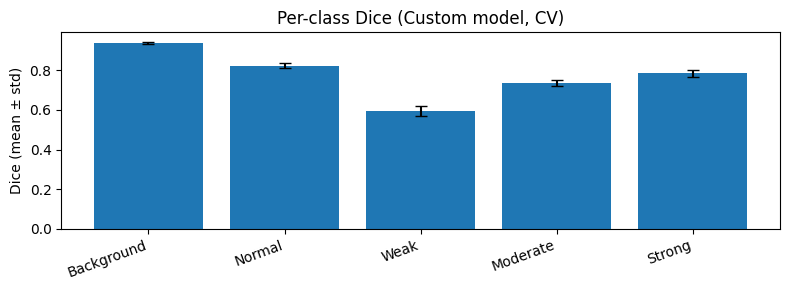

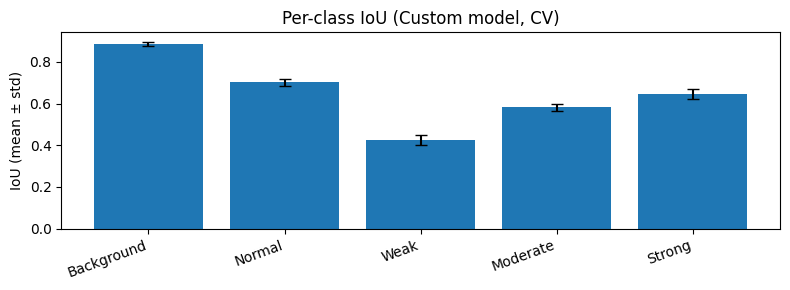

In [97]:
rows=[]
for f, s in enumerate(all_summ):
    row = {
        "fold": f,
        "pixel_acc": s["pixel_acc"],
        "miou": s["miou"],
        "mdice": s["mdice"],
        "miou_no_bg": s["miou_no_bg"],
        "mdice_no_bg": s["mdice_no_bg"],
        "minority_dice": s["minority_dice"]
    }
    for c in range(NUM_CLASSES):
        row[f"dice_c{c}"] = float(s["dice_per_class"][c])
        row[f"iou_c{c}"]  = float(s["iou_per_class"][c])
    rows.append(row)

cv_df = pd.DataFrame(rows)
cv_df.to_csv(OUT_DIR/"custom_cv_fold_summary.csv", index=False)

mean_std = cv_df.agg(["mean","std"])
mean_std.to_csv(OUT_DIR/"custom_cv_mean_std.csv")

display(cv_df)
display(mean_std)

# Per-class Dice & IoU bar plots (mean across folds)
dice_means = [cv_df[f"dice_c{c}"].mean() for c in range(NUM_CLASSES)]
dice_stds  = [cv_df[f"dice_c{c}"].std() for c in range(NUM_CLASSES)]
iou_means  = [cv_df[f"iou_c{c}"].mean() for c in range(NUM_CLASSES)]
iou_stds   = [cv_df[f"iou_c{c}"].std() for c in range(NUM_CLASSES)]

x = np.arange(NUM_CLASSES)

plt.figure(figsize=(8,3))
plt.bar(x, dice_means, yerr=dice_stds, capsize=4)
plt.xticks(x, [ID_TO_NAME[i] for i in range(NUM_CLASSES)], rotation=20, ha="right")
plt.ylabel("Dice (mean ± std)")
plt.title("Per-class Dice (Custom model, CV)")
plt.tight_layout()
plt.savefig(OUT_DIR/"custom_per_class_dice_bar.png", dpi=200)
plt.show()

plt.figure(figsize=(8,3))
plt.bar(x, iou_means, yerr=iou_stds, capsize=4)
plt.xticks(x, [ID_TO_NAME[i] for i in range(NUM_CLASSES)], rotation=20, ha="right")
plt.ylabel("IoU (mean ± std)")
plt.title("Per-class IoU (Custom model, CV)")
plt.tight_layout()
plt.savefig(OUT_DIR/"custom_per_class_iou_bar.png", dpi=200)
plt.show()


**Cell 16 — Qualitative Results (Image / GT / Pred) from fold0 best**

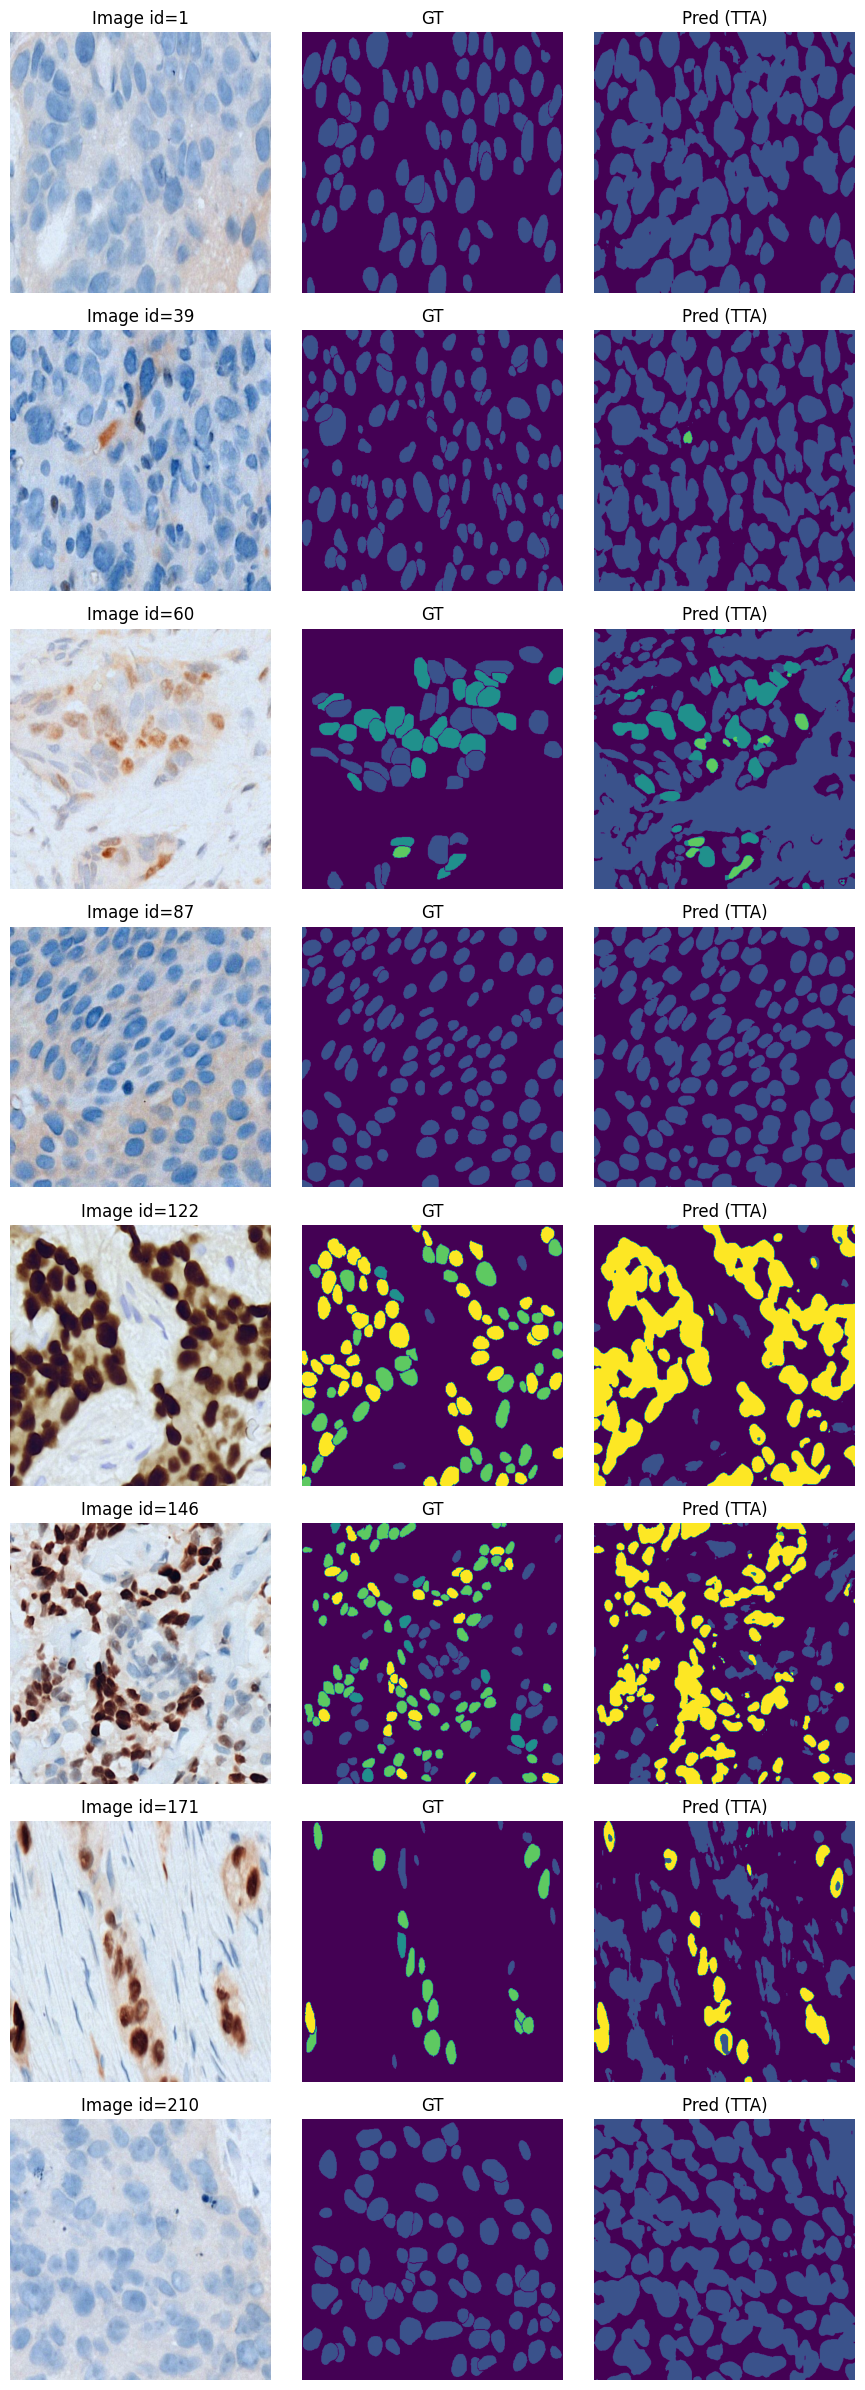

Saved: /kaggle/working/er_final_runs/custom_qual_fold0.png


In [98]:
@torch.no_grad()
def save_qual_panel_from_fold0(n=8):
    fold0_dir = OUT_DIR/"fold0"
    ck = torch.load(fold0_dir/"custom_best.pt", map_location=DEVICE)

    model = CustomDeepLabV3Plus_DS().to(DEVICE)
    model.load_state_dict(ck["model"])
    model.eval()

    # rebuild fold0 val pairs
    val_ids = set(pd.read_csv(OUT_DIR/"fold0_val_ids.csv")["id"].tolist())
    val_pairs = [p for p in pairs if p[2] in val_ids]
    val_pairs = sorted(val_pairs, key=lambda x: x[2])

    idxs = np.linspace(0, len(val_pairs)-1, n, dtype=int)
    tf = A.Compose([A.Normalize(IMAGENET_MEAN, IMAGENET_STD), ToTensorV2()])

    fig, axes = plt.subplots(n, 3, figsize=(9, 3*n))
    for r, idx in enumerate(idxs):
        img_path, msk_path, pid = val_pairs[idx]
        img = np.array(Image.open(img_path).convert("RGB"), dtype=np.uint8)
        gt = load_mask_ids(msk_path)

        x = tf(image=img)["image"].unsqueeze(0).float().to(DEVICE)
        logits = tta_logits(model, x)
        pred = logits.argmax(1)[0].cpu().numpy()

        # display-friendly image
        im = x[0].cpu().permute(1,2,0).numpy()
        im = (im - im.min())/(im.max()-im.min()+1e-8)

        axes[r,0].imshow(im); axes[r,0].set_title(f"Image id={pid}")
        axes[r,1].imshow(gt, vmin=0, vmax=NUM_CLASSES-1); axes[r,1].set_title("GT")
        axes[r,2].imshow(pred, vmin=0, vmax=NUM_CLASSES-1); axes[r,2].set_title("Pred (TTA)")
        for c in range(3): axes[r,c].axis("off")

    plt.tight_layout()
    out_path = OUT_DIR/"custom_qual_fold0.png"
    plt.savefig(out_path, dpi=200)
    plt.show()
    print("Saved:", out_path)

save_qual_panel_from_fold0(n=8)


**Cell 15 — Dataset imbalance plots (images-per-class + pixel-per-class)**

,class_id,class_name,images_with_class,pixel_count,pixel_frac
0,0,Background,220,44073570,0.764215
1,1,Normal,218,10208024,0.177002
2,2,Weak,127,886332,0.015369
3,3,Moderate,93,1496739,0.025953
4,4,Strong,65,1007015,0.017461


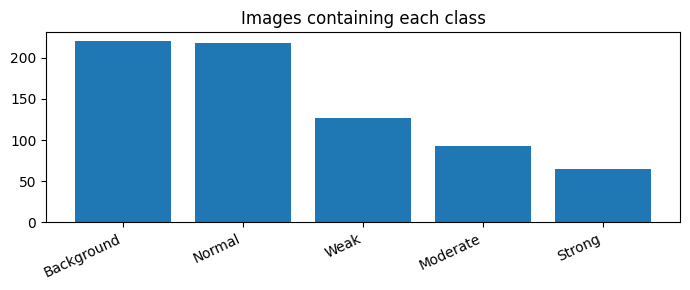

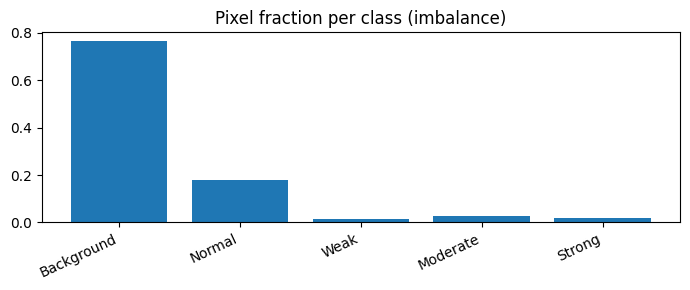

In [102]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# images containing each class
img_has = {c: 0 for c in range(NUM_CLASSES)}
pix_counts = {c: 0 for c in range(NUM_CLASSES)}

for _, msk, _ in pairs:
    lbl = load_mask_ids(msk)
    for c in range(NUM_CLASSES):
        img_has[c] += int((lbl == c).any())
        pix_counts[c] += int((lbl == c).sum())

df_dist = pd.DataFrame({
    "class_id": list(range(NUM_CLASSES)),
    "class_name": [ID_TO_NAME[i] for i in range(NUM_CLASSES)],
    "images_with_class": [img_has[i] for i in range(NUM_CLASSES)],
    "pixel_count": [pix_counts[i] for i in range(NUM_CLASSES)],
})
df_dist["pixel_frac"] = df_dist["pixel_count"] / df_dist["pixel_count"].sum()

display(df_dist)

plt.figure(figsize=(7,3))
plt.bar(df_dist["class_name"], df_dist["images_with_class"])
plt.title("Images containing each class")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,3))
plt.bar(df_dist["class_name"], df_dist["pixel_frac"])
plt.title("Pixel fraction per class (imbalance)")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()


**Cell 16 — Normalized confusion matrix**

In [103]:
def plot_confusion_matrix(cm, class_names, normalize=True, title="Confusion Matrix", out_path=None):
    cm = cm.astype(np.float64)
    if normalize:
        cm = cm / (cm.sum(axis=1, keepdims=True) + 1e-12)

    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title + (" (normalized)" if normalize else ""))
    plt.colorbar()
    plt.xticks(range(len(class_names)), class_names, rotation=30, ha="right")
    plt.yticks(range(len(class_names)), class_names)

    # annotate
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            v = cm[i, j]
            txt = f"{v:.2f}" if normalize else f"{int(v)}"
            plt.text(j, i, txt, ha="center", va="center", fontsize=8)

    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=200)
    plt.show()

# Example: aggregate fold confusion matrices if you saved them;
# If you have per-fold cm saved in folds, load and sum them.
import glob, os
cms = []
for fold in range(FOLDS):
    # If you saved cm as image only, skip; if you saved cm as .npy then load.
    # Suggested: save cm as fold_dir/"custom_cm.npy" in train_one_fold_custom (optional).
    npy = OUT_DIR / f"fold{fold}" / "custom_cm.npy"
    if npy.exists():
        cms.append(np.load(npy))

if len(cms) > 0:
    cm_total = np.sum(cms, axis=0)
    plot_confusion_matrix(cm_total, [ID_TO_NAME[i] for i in range(NUM_CLASSES)],
                          normalize=True, title="Custom model confusion matrix",
                          out_path=str(OUT_DIR/"custom_confusion_matrix_normalized.png"))
else:
    print("No .npy confusion matrices found. (Optional) Save cm as .npy inside train_one_fold_custom.")


No .npy confusion matrices found. (Optional) Save cm as .npy inside train_one_fold_custom.


**Cell 17 — Fold stability plots (boxplots)**

,fold,pixel_acc,miou,mdice,miou_no_bg,mdice_no_bg,minority_dice,dice_c0,iou_c0,dice_c1,iou_c1,dice_c2,iou_c2,dice_c3,iou_c3,dice_c4,iou_c4
0,0,0.898149,0.645270,0.775186,0.586738,0.735024,0.704456,0.935831,0.879401,0.826729,0.704637,0.616897,0.446024,0.728423,0.572850,0.768048,0.623440
1,1,0.913272,0.666673,0.790967,0.608193,0.751785,0.726328,0.947697,0.900593,0.828156,0.706711,0.624998,0.454543,0.756819,0.608776,0.797166,0.662740
2,2,0.906444,0.657869,0.782814,0.599417,0.742834,0.711322,0.942736,0.891675,0.837368,0.720234,0.596474,0.424982,0.727047,0.571150,0.810446,0.681302
3,3,0.892859,0.628850,0.760618,0.566573,0.717019,0.687230,0.935014,0.877960,0.806384,0.675580,0.564652,0.393390,0.725249,0.568934,0.771790,0.628386
4,4,0.900388,0.644278,0.772707,0.583939,0.731047,0.700460,0.939349,0.885635,0.822807,0.698957,0.579812,0.408264,0.742702,0.590713,0.778865,0.637821


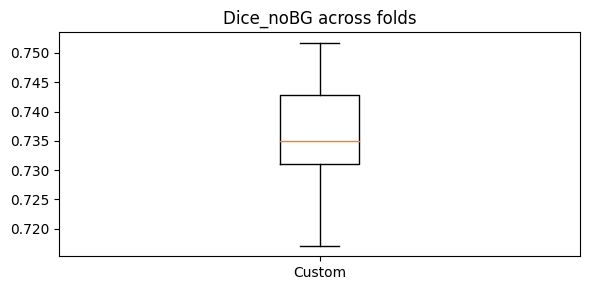

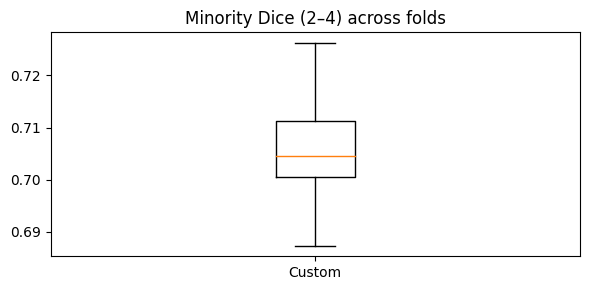

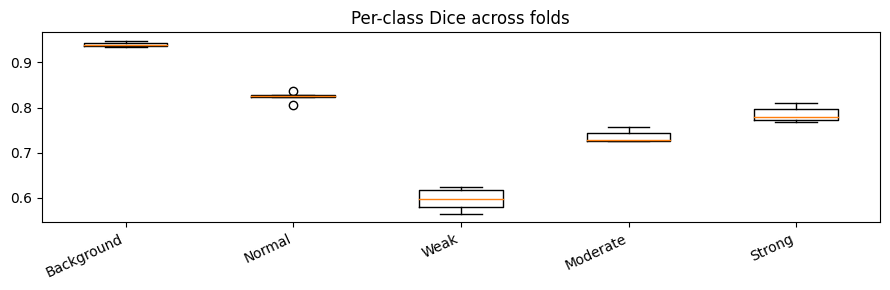

In [104]:
import pandas as pd
import matplotlib.pyplot as plt

# assuming you saved fold summaries into OUT_DIR/"custom_cv_fold_summary.csv"
custom_cv = pd.read_csv(OUT_DIR/"custom_cv_fold_summary.csv")
display(custom_cv)

plt.figure(figsize=(6,3))
plt.boxplot(custom_cv["mdice_no_bg"], labels=["Custom"])
plt.title("Dice_noBG across folds")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.boxplot(custom_cv["minority_dice"], labels=["Custom"])
plt.title("Minority Dice (2–4) across folds")
plt.tight_layout()
plt.show()

# per-class dice boxplots (optional)
dice_cols = [f"dice_c{i}" for i in range(NUM_CLASSES)]
plt.figure(figsize=(9,3))
plt.boxplot([custom_cv[c] for c in dice_cols], labels=[ID_TO_NAME[i] for i in range(NUM_CLASSES)])
plt.title("Per-class Dice across folds")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()


**Cell 18 — Paper-style qualitative overlay (GT vs Pred contours)**

In [112]:
!pip -q install scikit-image


In [113]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from matplotlib.lines import Line2D

# ---- Paper-friendly class colors (fixed, consistent across all figures) ----
# (BG is not drawn; only classes 1-4)
CLASS_COLORS = {
    1: (0.00, 0.60, 1.00),  # Normal  (cyan-ish)
    2: (0.00, 0.80, 0.20),  # Weak    (green)
    3: (1.00, 0.60, 0.00),  # Moderate(orange)
    4: (1.00, 0.00, 0.20),  # Strong  (red)
}

def mask_to_contours(mask, cls, min_len=20):
    """Return list of contour arrays for a given class."""
    m = (mask == cls).astype(np.uint8)
    contours = measure.find_contours(m, 0.5)
    return [c for c in contours if len(c) >= min_len]

def show_qualitative_results(image_rgb, gt_ids, pred_ids,
                             class_ids=(1,2,3,4),
                             title="Qualitative segmentation results (Ground Truth vs. Prediction)",
                             save_path=None,
                             min_contour_len=20):
    """
    Paper figure:
      Left: image
      Middle: image + GT contours
      Right: image + Pred contours
    """
    fig = plt.figure(figsize=(12, 4))

    # Panel 1: Image
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(image_rgb)
    ax1.set_title("Input image")
    ax1.axis("off")

    # Panel 2: GT contours
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(image_rgb)
    for c in class_ids:
        color = CLASS_COLORS.get(c, (1,1,1))
        for cont in mask_to_contours(gt_ids, c, min_len=min_contour_len):
            ax2.plot(cont[:,1], cont[:,0], linewidth=2, color=color)
    ax2.set_title("Ground Truth (contours)")
    ax2.axis("off")

    # Panel 3: Pred contours
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(image_rgb)
    for c in class_ids:
        color = CLASS_COLORS.get(c, (1,1,1))
        for cont in mask_to_contours(pred_ids, c, min_len=min_contour_len):
            ax3.plot(cont[:,1], cont[:,0], linewidth=2, color=color)
    ax3.set_title("Prediction (contours)")
    ax3.axis("off")

    # Legend (class names)
    legend_elems = []
    for c in class_ids:
        name = ID_TO_NAME.get(c, f"class {c}")
        legend_elems.append(Line2D([0], [0], color=CLASS_COLORS[c], lw=3, label=name))
    fig.legend(handles=legend_elems, loc="lower center", ncol=len(class_ids), frameon=False)

    fig.suptitle(title, y=1.02, fontsize=13)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


**BASELINES**

**Cell 19 — Install segmentation_models_pytorch (for pretrained U-Net)**

In [115]:
!pip -q install -U segmentation-models-pytorch==0.3.3 timm==1.0.8
!pip -q install -U segmentation-models-pytorch timm

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
ERROR: Cannot install segmentation-models-pytorch==0.3.3 and timm==1.0.8 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

**Cell 20 — Define Baseline Models (Pretrained DeepLabV3+ and Pretrained U-Net)**

In [116]:
import torch
import torch.nn as nn
import torchvision
import segmentation_models_pytorch as smp

class TorchDeepLabV3(nn.Module):
    """Pretrained DeepLabV3-ResNet50 baseline (ImageNet backbone)."""
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        m = torchvision.models.segmentation.deeplabv3_resnet50(weights="DEFAULT")  # backbone pretrained
        # replace classifier head
        in_ch = m.classifier[-1].in_channels
        m.classifier[-1] = nn.Conv2d(in_ch, num_classes, kernel_size=1)
        self.m = m

    def forward(self, x):
        out = self.m(x)["out"]
        return out

class SMPUNet(nn.Module):
    """Pretrained U-Net baseline (ImageNet encoder)."""
    def __init__(self, num_classes=NUM_CLASSES, encoder="resnet34"):
        super().__init__()
        self.m = smp.Unet(
            encoder_name=encoder,
            encoder_weights="imagenet",
            in_channels=3,
            classes=num_classes,
            activation=None
        )
    def forward(self, x):
        return self.m(x)


**Cell 21 — Baseline training loop (no aux head)**

In [117]:
import time, math
import torch.nn.functional as F
from torch.utils.data import DataLoader

def train_one_fold_baseline(model_name, model_fn, fold, train_pairs, val_pairs):
    fold_dir = OUT_DIR / f"{model_name}_fold{fold}"
    fold_dir.mkdir(parents=True, exist_ok=True)

    ds_tr = ERDataset(
        train_pairs, train=True, crop_size=CROP_SIZE,
        samples_per_image=SAMPLES_PER_IMAGE,
        focus_prob=FOCUS_PROB,
        guarantee_classes=(2,3,4),
        use_geo_aug=USE_GEO_AUG,
        p_lesion=0.60, p_fg=0.30
    )
    ds_va = ERDataset(
        val_pairs, train=False, crop_size=CROP_SIZE,
        samples_per_image=1, focus_prob=0.0,
        guarantee_classes=(),
        use_geo_aug=False
    )

    dl_tr = DataLoader(ds_tr, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
    dl_va = DataLoader(ds_va, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

    model = model_fn().to(DEVICE)

    # weights (same strategy as custom)
    counts = compute_train_class_counts(train_pairs)
    w = effective_num_weights(counts, beta=0.9999)
    w = np.clip(w, 0.5, 5.0)
    w[0] = min(w[0], 0.2)
    w = w / w.mean()
    ce_w = torch.tensor(w, dtype=torch.float32, device=DEVICE)
    print(f"[{model_name} Fold {fold}] CE weights:", w)

    ce_only = nn.CrossEntropyLoss(weight=ce_w)
    combo = ComboLoss(ce_w, w_ce=1.0, w_dice=1.0, use_tversky=False)

    # pretrained baseline LR should be smaller than scratch
    BASE_LR = 3e-4
    opt = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=WD)
    scaler = torch.amp.GradScaler("cuda", enabled=(DEVICE == "cuda"))

    best = -1e9
    bad = 0
    best_path = fold_dir / "best.pt"
    hist = []

    for ep in range(EPOCHS):
        model.train()

        # warmup cosine
        lr_now = warmup_cosine_lr(ep, EPOCHS, BASE_LR, warmup_epochs=5)
        for g in opt.param_groups:
            g["lr"] = lr_now

        t0 = time.time()
        run_loss = 0.0

        for x, y, _ in dl_tr:
            x = x.to(DEVICE, non_blocking=True)
            y = y.to(DEVICE, non_blocking=True)

            opt.zero_grad(set_to_none=True)

            with torch.amp.autocast("cuda", enabled=(DEVICE == "cuda")):
                logits = model(x)

                # CE-only warmup first 10 epochs
                if ep < 10:
                    loss = ce_only(logits, y)
                else:
                    loss = combo(logits, y)

            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt)
            scaler.update()

            run_loss += loss.item() * x.size(0)

        train_loss = run_loss / len(dl_tr.dataset)

        val_summ, per_img, cm = evaluate(model, dl_va, use_tta=True)
        score = val_summ["minority_dice"]

        hist.append({
            "epoch": ep+1, "lr": lr_now, "train_loss": train_loss,
            "val_mdice_no_bg": val_summ["mdice_no_bg"],
            "val_minority_dice": val_summ["minority_dice"],
        })

        print(f"[{model_name} Fold {fold}] ep {ep+1:02d} "
              f"lr={lr_now:.2e} loss={train_loss:.4f} "
              f"mdice_noBG={val_summ['mdice_no_bg']:.4f} "
              f"minorDice(2-4)={val_summ['minority_dice']:.4f} "
              f"time={time.time()-t0:.1f}s")

        if score > best + 1e-4:
            best = score
            bad = 0
            torch.save({"model": model.state_dict(), "epoch": ep+1, "best_minor": best}, best_path)
        else:
            bad += 1
            if bad >= PATIENCE:
                print("Early stopping.")
                break

    hist_df = pd.DataFrame(hist)
    hist_df.to_csv(fold_dir/"history.csv", index=False)

    ck = torch.load(best_path, map_location=DEVICE)
    model.load_state_dict(ck["model"])
    val_summ, per_img, cm = evaluate(model, dl_va, use_tta=True)
    per_img.to_csv(fold_dir/"per_image.csv", index=False)
    np.save(fold_dir/"cm.npy", cm)

    return val_summ, per_img


**Cell 22 — Run CV for both baselines (same folds as your strat_labels)**

In [118]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
pairs_arr = np.array(pairs, dtype=object)

baseline_results = {}

def run_model_cv(model_name, model_fn):
    all_summ = []
    for fold, (tr_idx, va_idx) in enumerate(skf.split(np.zeros(len(pairs)), strat_labels)):
        seed_everything(SEED + fold)

        train_pairs = pairs_arr[tr_idx].tolist()
        val_pairs   = pairs_arr[va_idx].tolist()

        val_summ, per_img = train_one_fold_baseline(model_name, model_fn, fold, train_pairs, val_pairs)
        all_summ.append(val_summ)

    df = pd.DataFrame([
        {
            "fold": i,
            "mdice_no_bg": s["mdice_no_bg"],
            "minority_dice": s["minority_dice"],
            **{f"dice_c{c}": float(s["dice_per_class"][c]) for c in range(NUM_CLASSES)},
            **{f"iou_c{c}": float(s["iou_per_class"][c]) for c in range(NUM_CLASSES)},
        } for i, s in enumerate(all_summ)
    ])
    df.to_csv(OUT_DIR/f"{model_name}_cv_fold_summary.csv", index=False)
    return df

# 1) Pretrained DeepLabV3 baseline
baseline_results["deeplabv3_pre"] = run_model_cv(
    "deeplabv3_pre",
    lambda: TorchDeepLabV3(NUM_CLASSES)
)

# 2) Pretrained U-Net baseline (resnet34 encoder)
baseline_results["unet_pre"] = run_model_cv(
    "unet_pre",
    lambda: SMPUNet(NUM_CLASSES, encoder="resnet34")
)

display(baseline_results["deeplabv3_pre"])
display(baseline_results["unet_pre"])


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 189MB/s] 


[deeplabv3_pre Fold 0] CE weights: [0.23809524 1.19047619 1.19047619 1.19047619 1.19047619]


ValueError: too many values to unpack (expected 2)

**STATISTICAL SIGNIFICANCE + FINAL TABLES**

**Cell 23 — Compare models + Wilcoxon tests + 95% CI**

In [ ]:
import numpy as np, pandas as pd
from scipy.stats import wilcoxon

custom_df = pd.read_csv(OUT_DIR/"custom_cv_fold_summary.csv")
deeplab_df = pd.read_csv(OUT_DIR/"deeplabv3_pre_cv_fold_summary.csv")
unet_df    = pd.read_csv(OUT_DIR/"unet_pre_cv_fold_summary.csv")

def mean_std_ci(x):
    x = np.asarray(x, dtype=np.float64)
    m = x.mean()
    s = x.std(ddof=1)
    # 95% CI with t-approx (n=5)
    n = len(x)
    t = 2.776  # t_{0.975, df=4} ~ 2.776
    ci = t * s / np.sqrt(n)
    return m, s, (m-ci, m+ci)

def wilcoxon_p(a, b):
    a = np.asarray(a); b = np.asarray(b)
    # handle identical arrays
    if np.allclose(a, b):
        return 1.0
    return wilcoxon(a, b, zero_method="wilcox", alternative="two-sided").pvalue

metrics_main = ["mdice_no_bg", "minority_dice", "dice_c2", "dice_c3", "dice_c4"]

rows = []
for metric in metrics_main:
    c_m, c_s, c_ci = mean_std_ci(custom_df[metric])
    d_m, d_s, d_ci = mean_std_ci(deeplab_df[metric])
    u_m, u_s, u_ci = mean_std_ci(unet_df[metric])

    p_cd = wilcoxon_p(custom_df[metric], deeplab_df[metric])
    p_cu = wilcoxon_p(custom_df[metric], unet_df[metric])

    rows.append({
        "metric": metric,
        "custom_mean": c_m, "custom_std": c_s, "custom_ci95_low": c_ci[0], "custom_ci95_high": c_ci[1],
        "deeplab_mean": d_m, "deeplab_std": d_s, "deeplab_ci95_low": d_ci[0], "deeplab_ci95_high": d_ci[1],
        "unet_mean": u_m, "unet_std": u_s, "unet_ci95_low": u_ci[0], "unet_ci95_high": u_ci[1],
        "p_custom_vs_deeplab": p_cd,
        "p_custom_vs_unet": p_cu
    })

final_stats = pd.DataFrame(rows)
final_stats.to_csv(OUT_DIR/"paper_stats_significance.csv", index=False)
display(final_stats)


**Cell 24 — Final “paper table” export (mean ± std)**

In [ ]:
def summarize_table(df, name):
    m = df.mean(numeric_only=True)
    s = df.std(numeric_only=True, ddof=1)
    out = {}
    for col in ["mdice_no_bg", "minority_dice"] + [f"dice_c{i}" for i in range(NUM_CLASSES)] + [f"iou_c{i}" for i in range(NUM_CLASSES)]:
        if col in df.columns:
            out[col] = f"{m[col]:.4f} ± {s[col]:.4f}"
    return pd.Series(out, name=name)

paper_table = pd.concat([
    summarize_table(custom_df, "Custom (yours)"),
    summarize_table(deeplab_df, "DeepLabV3+ pretrained"),
    summarize_table(unet_df, "U-Net pretrained"),
], axis=1)

paper_table.to_csv(OUT_DIR/"paper_table_mean_std.csv")
display(paper_table)
